based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.

In [49]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
from astropy.stats import sigma_clipped_stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from astroquery.gaia import Gaia
from jwst.datamodels import ImageModel

from scipy.ndimage import binary_dilation
from copy import deepcopy

import jhat
from jhat import jwst_photclass,st_wcs_align, hst_photclass

from nbutils import xmatch_common

## Relative Alignment

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [83]:
ref_image = glob.glob('jwstred_temp_gaia/f277w_jhat_i2d.fits')[0]

In [84]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80,use_dq=True)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/f277w_jhat_i2d.phot.txt


2024-10-24 16:54:33,689 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-10-24 16:54:33,860 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /Users/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-10-24 16:54:33,864 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /Users/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-10-24 16:54:33,864 - stpipe - INFO - Instrument: NIRCAM
2024-10-24 16:54:33,865 - stpipe - INFO - Detector: NRCALONG
2024-10-24 16:54:33,865 - stpipe - INFO - Filter: F277W
2024-10-24 16:54:33,865 - stpipe - INFO - Pupil: CLEAR
2024-10-24 16:54:33,865 - stpipe - INFO - Subarray: FULL


dmag 0.36200000000000004
aper_sum_3.1px annulus_median_3.1px aper_bkg_3.1px ...   x_idl     y_idl   
-------------- -------------------- -------------- ... --------- ----------
     32.743482             0.415316      12.425693 ... 43.479657 -64.765938
      34.91476             0.331131       9.906975 ... 45.175068 -64.765808
     17.723102             0.282308        8.44627 ... 52.384012 -64.737681
      93.12083              0.77046      23.051095 ... 58.425765 -64.743491
     18.711702             0.457963       13.70163 ... 61.838519 -64.687523
    137.970653             4.183688     125.170205 ... 20.742178 -64.622353
    170.718659             3.723311     111.396374 ... 22.138594 -64.628996
     11.189172              0.22884       6.846589 ... 25.205835 -64.596996
     32.858963             0.325017       9.724053 ... 32.926848 -64.576308
     42.690499             0.585415       17.51481 ... -2.179115 -64.382083
           ...                  ...            ... ...       ..

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [85]:
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca1_cal.fits')[0]

In [89]:
refcat_df = pd.read_csv(ref_catname, sep = '\s+')

In [90]:
refcat_df

aper_sum_3.1px  annulus_median_3.1px  aper_bkg_3.1px  \
0           32.743482              0.415316       12.425693   
1           34.914760              0.331131        9.906975   
2           17.723102              0.282308        8.446270   
3           93.120830              0.770460       23.051095   
4           18.711702              0.457963       13.701630   
...               ...                   ...             ...   
35192       15.883481              0.494639       14.798933   
35193       94.907056              0.418536       12.522022   
35194       18.185354              0.320050        9.575448   
35195       37.665129              0.325734        9.745523   
35196       33.153306              0.383351       11.469345   

       aper_sum_bkgsub_3.1px  flux_err_3.1px        mag      dmag  \
0                  26.268868        0.000797  22.930063  0.008298   
1                  32.332565        0.000741  22.704566  0.006267   
2                  11.994016        0.000517  23.781255  0.011756   
3                  90.593159        0.001539  21.585928  0.004652   
4                   6.477522        0.000532  24.450144  0.022316   
...                      ...             ...        ...       ...   
35192               1.402211        0.000467  26.111633  0.087661   
35193             106.515608        0.001479  21.410133  0.003803   
35194              11.131747        0.000486  23.862258  0.011903   
35195              36.097258        0.000759  22.584981  0.005755   
35196              28.035192        0.000690  22.859408  0.006729   

                 x            y  sharpness  roundness1  roundness2  \
0      1707.147576     7.267862   0.763070    0.994518    0.328032   
1      1733.663413     7.289626   0.724772   -0.484005    0.024112   
2      1846.327071     7.758555   0.742007   -0.152073    0.030519   
3      1940.631575     7.631811   0.624712    0.769663    0.729416   
4      1993.862514     8.451099   0.706605    0.036965    0.167123   
...            ...          ...        ...         ...         ...   
35192  1969.786806  2067.400433   0.786639   -0.242583   -0.114297   
35193  1915.825110  2069.380862   0.762114   -0.330632    0.222938   
35194  2028.212275  2068.775231   0.811447    0.023440    0.089088   
35195  2006.310691  2069.727512   0.772378   -0.059429    0.130520   
35196  2014.448087  2069.686746   0.777171   -0.475639    0.165220   

               ra        dec      x_idl      y_idl  
0      259.258138  43.151451  43.479657 -64.765938  
1      259.258763  43.151532  45.175068 -64.765808  
2      259.261421  43.151871  52.384012 -64.737681  
3      259.263644  43.152162  58.425765 -64.743491  
4      259.264903  43.152312  61.838519 -64.687523  
...           ...        ...        ...        ...  
35192  259.272998  43.116820  58.861099  65.998163  
35193  259.271735  43.116620  55.482365  66.072077  
35194  259.274381  43.116976  62.519679  66.142333  
35195  259.273869  43.116892  61.146862  66.180169  
35196  259.274060  43.116918  61.656655  66.185742  

[35197 rows x 16 columns]

In [93]:
hdr = fits.open(ref_image)['SCI'].header
w = wcs.WCS(hdr)
jh_radec = w.all_pix2world(refcat_df['x'], refcat_df['y'], 0)
refcat['ra'], refcat['dec'] = jh_radec[0], jh_radec[1]

In [99]:
refcat.write('jwstred_temp_gaia/f277w_jhat_i2d.phot.txt', format='ascii', overwrite=True)

In [4]:
ref_catname = 'jwstred_temp_dolphot/jhat/f277w_jhat_i2d.phot.txt'

In [ ]:
wcs_align = st_wcs_align()
align_images = glob.glob('jwstred_temp_dolphot/jhat/*04101*cal.fits')

for align_image in align_images:
    wcs_align.run_all(align_image,
                      telescope='jwst',
                      outsubdir='jwstred_temp_dolphot/jhat',
                      refcat_racol='ra',
                      refcat_deccol='dec',
                      refcat_magcol='mag',
                      refcat_magerrcol='dmag',
                      overwrite=True,
                      d2d_max=1.0,
                      showplots=2,
                      find_stars_threshold=5,
                      refcatname=ref_catname,
                      iterate_with_xyshifts = True,
                      histocut_order='dxdy',
                      sharpness_lim=(0.3,0.95),
                      roundness1_lim=(-0.7, 0.7),
                      xshift = -61,
                      yshift = 12,
                      SNR_min= 5,
                      dmag_max=0.1,
                      Nbright=800,
                      objmag_lim =(15,22),
                      slope_min = -20/2048,
                      binsize_px = 1.0)

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [2]:
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0] #short wavelength
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')[0] #long wavelength
# align_image = glob.glob('jwstred_temp_dolphot/out_filter/f150w_i2d.fits')[0]
align_image = glob.glob('sn2024aecx/ifab18050_drc.fits')[0]
# align_image = glob.glob('jwstred_temp_gaia/f277w_i2d.fits')[0] #level3 file
# align_image = glob.glob('jwstred_temp_mosaic/jw02784002001_02101_00001_nrcb1_cal.fits')[0]

In [8]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

In [9]:
_df = pd.read_csv('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal_region.txt', sep = '\s+', header = None)
_df[0], _df[1] = _df[0]+1, _df[1]+1
np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), _df.values, fmt='%s')

telescope set to hst

### Doing photometry on sn2024aecx/ifab18050_drc.fits
True ./sn2024aecx/ifab18050.phot.txt
photometry catalog filename: ./sn2024aecx/ifab18050.phot.txt
Instrument: WFC3, aperture:IUVISCENTER
Finding stars --- Detector: None, Filter: F336W
FWHM for the filter F336W: 2 px
Background and rms using MMMBackground and MADStdBackgroundRMS: 0.00023144320584833622 0.00885790426156134

Number of sources found in the image: 23753
-------------------------------------

radii:[4]pixels radius_sky_in:12 radius_sky_out:20  radius_for_mag:[4]
Performing aperture photometry for radius r = 4 px
Time Elapsed: 4.201049125054851
16088 objects left after removing entries with NaNs in mag or dmag column
dmag 0.2172
SNR_min cut: 6826 objects left after removing entries dmag>0.2172 (SNR<5)
6826 out of 17736 entries remain in photometry table
Saving ./sn2024aecx/ifab18050.phot.txt
########### !!!!!!!!!!  INITIAL CUT on image photometry cat: starting with 17736 objects
dmag_max =0.1 CUT:
dm

2025-01-08 12:36:36,956 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 55
### NO propoer motion correction!!!
Number of stars after removing nan's: 55
########### !!!!!!!!!!  INITIAL CUT on reference catalog: starting with 55 objects
55 of image photometry objects pass initial cuts #1, 0 cut
Matching reference catalog Gaia
x 4091
y 4437
Keeping 29 out of 55 catalog objects within x=40.0-4091 and y=40.0-4437
Keeping 29  after removing NaNs from ra/dec
!! Matching 2423 image objects to 29 refcat objects!
Saving refcat file into ./sn2024aecx/ifab18050.refcat.txt
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 2423 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
58 left
58 of image photometry objects pass initial cuts #1, 2365 cut
dx median: 0.02594614389659
dy median: -0.12738059046682793
*** Note: close plot to continue!


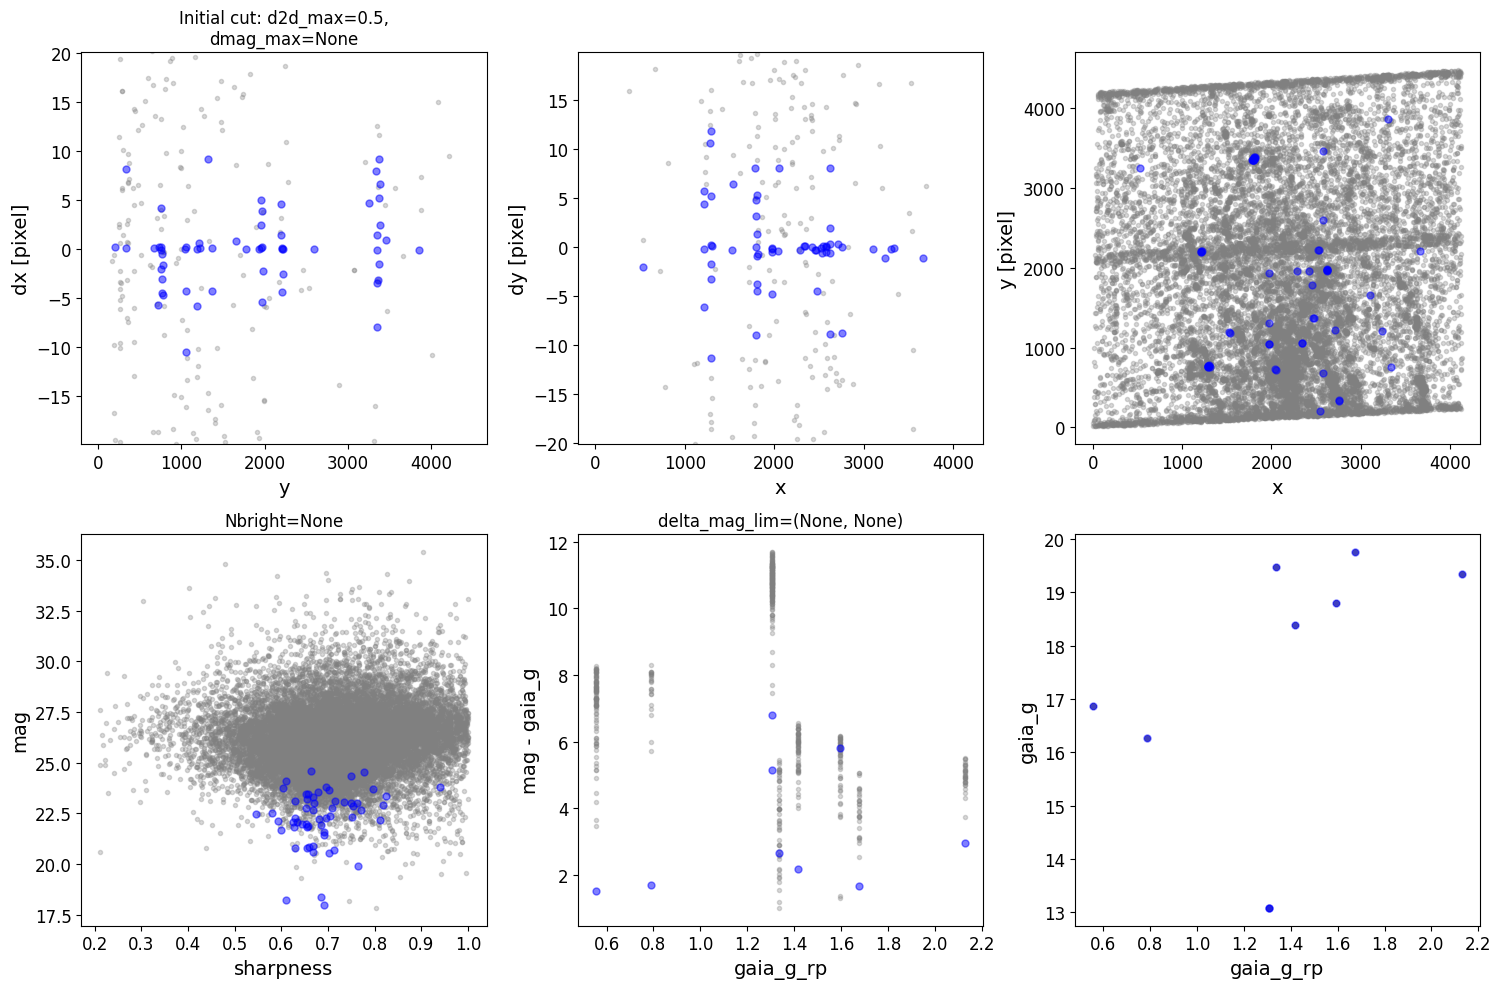

### Doing histogram cut for dx, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000098   0.218604    22.0     11    -0.223429   2.0     False
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.5765710109187598

rough_cut_px=0.8 pixels removes 35 from 58 entries
Keeping 23 out of 23, skippin 0 because of null values in columns d_rot_tmp
median: -0.009174
75.000000 percentile cut: max residual for cut: 0.123433
__tmp_residuals 0.12343270701019687
median: 0.002031
i:00 mean:0.002031(0.015975) stdev:0.063899(0.010959) X2norm:0.97 Nchanged:0 Ngood:17 Nc

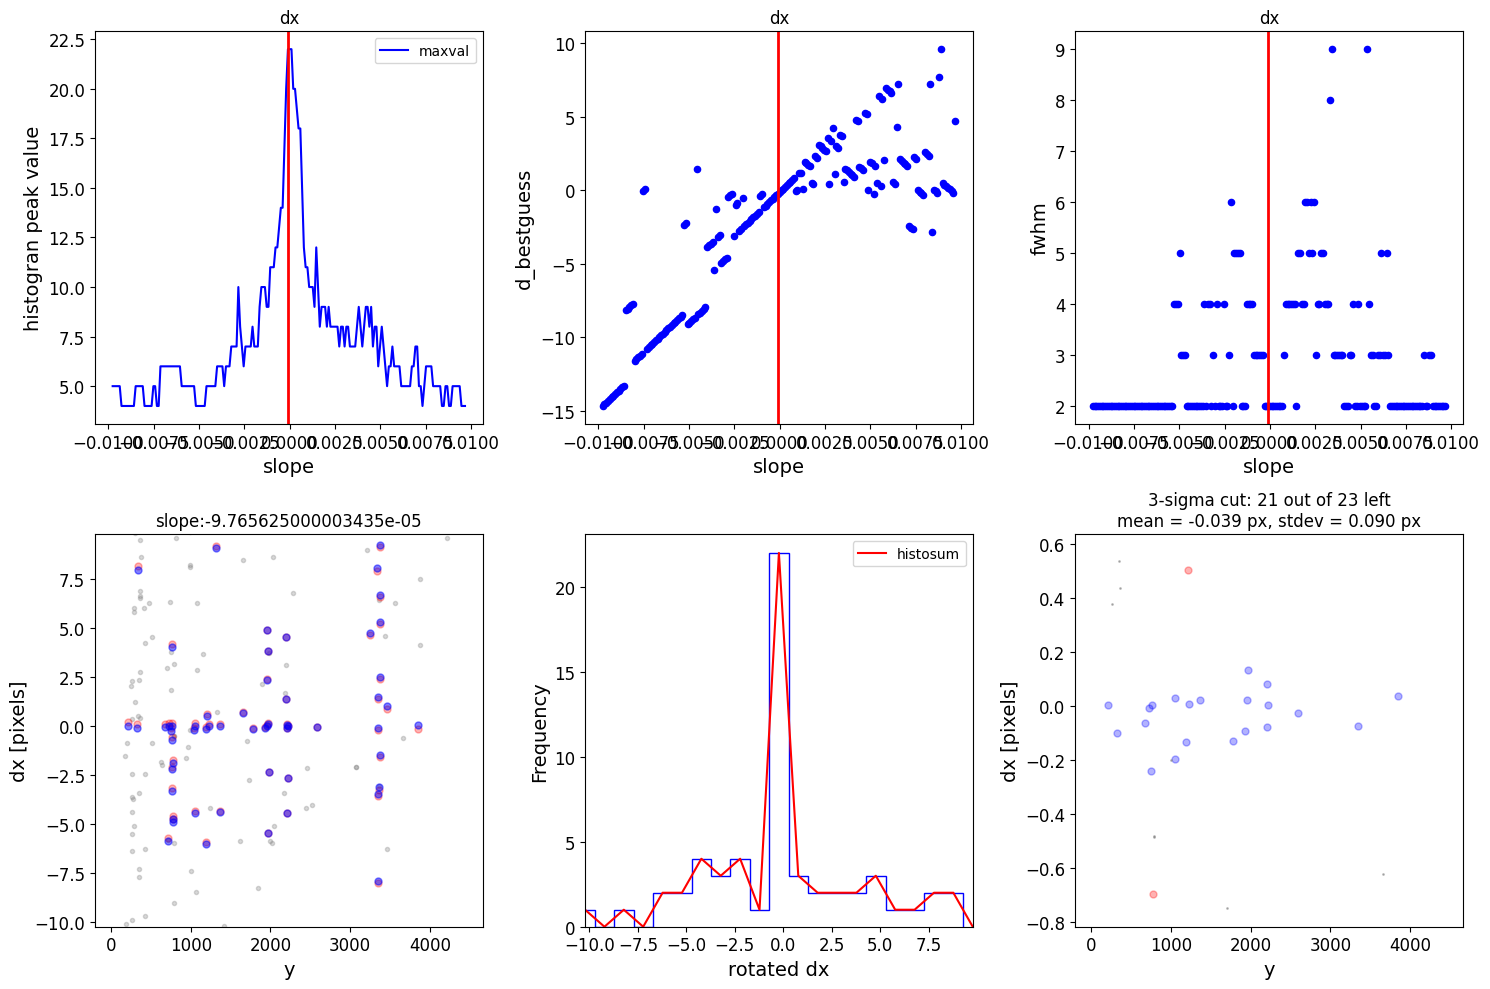

### Doing histogram cut for dy, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000391   0.806836    20.0      1     -0.01835   2.0     False
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.7816504175241705

rough_cut_px=0.8 pixels removes 0 from 21 entries
Keeping 21 out of 21, skippin 0 because of null values in columns d_rot_tmp
median: -0.101300
75.000000 percentile cut: max residual for cut: 0.417049
__tmp_residuals 0.41704942855791094
median: -0.128967
i:00 mean:-0.128967(0.070148) stdev:0.262470(0.047920) X2norm:0.96 Nchanged:0 Ngood:15 N

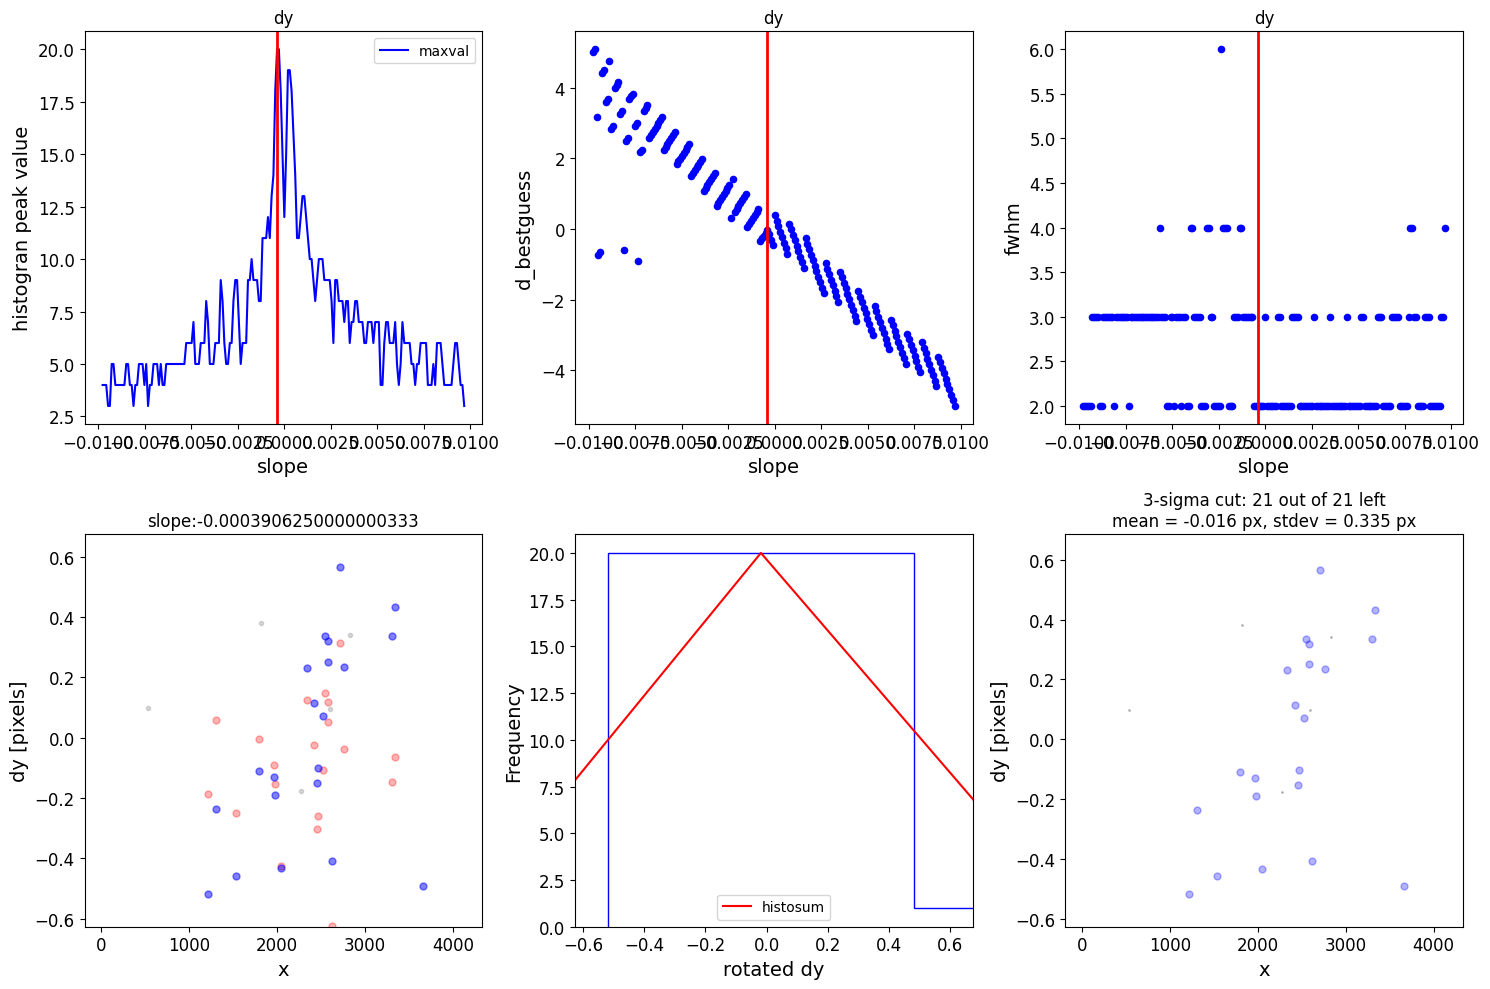

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

dx median of best matched objects of 1st iteration: 0.047764442781044636 dy median of best matched objects of 1st iteration: -0.09117765410633183
Matching reference catalog Gaia
x 4091
y 4437
Keeping 29 out of 55 catalog objects within x=40.0-4091 and y=40.0-4437
Keeping 29  after removing NaNs from ra/dec
!! Matching 2423 image objects to 29 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 2423 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
58 left
58 of image photometry objects pass initial cuts #1, 2365 cut
### Doing histogram cut for dx, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000098   0.218604    22.0     

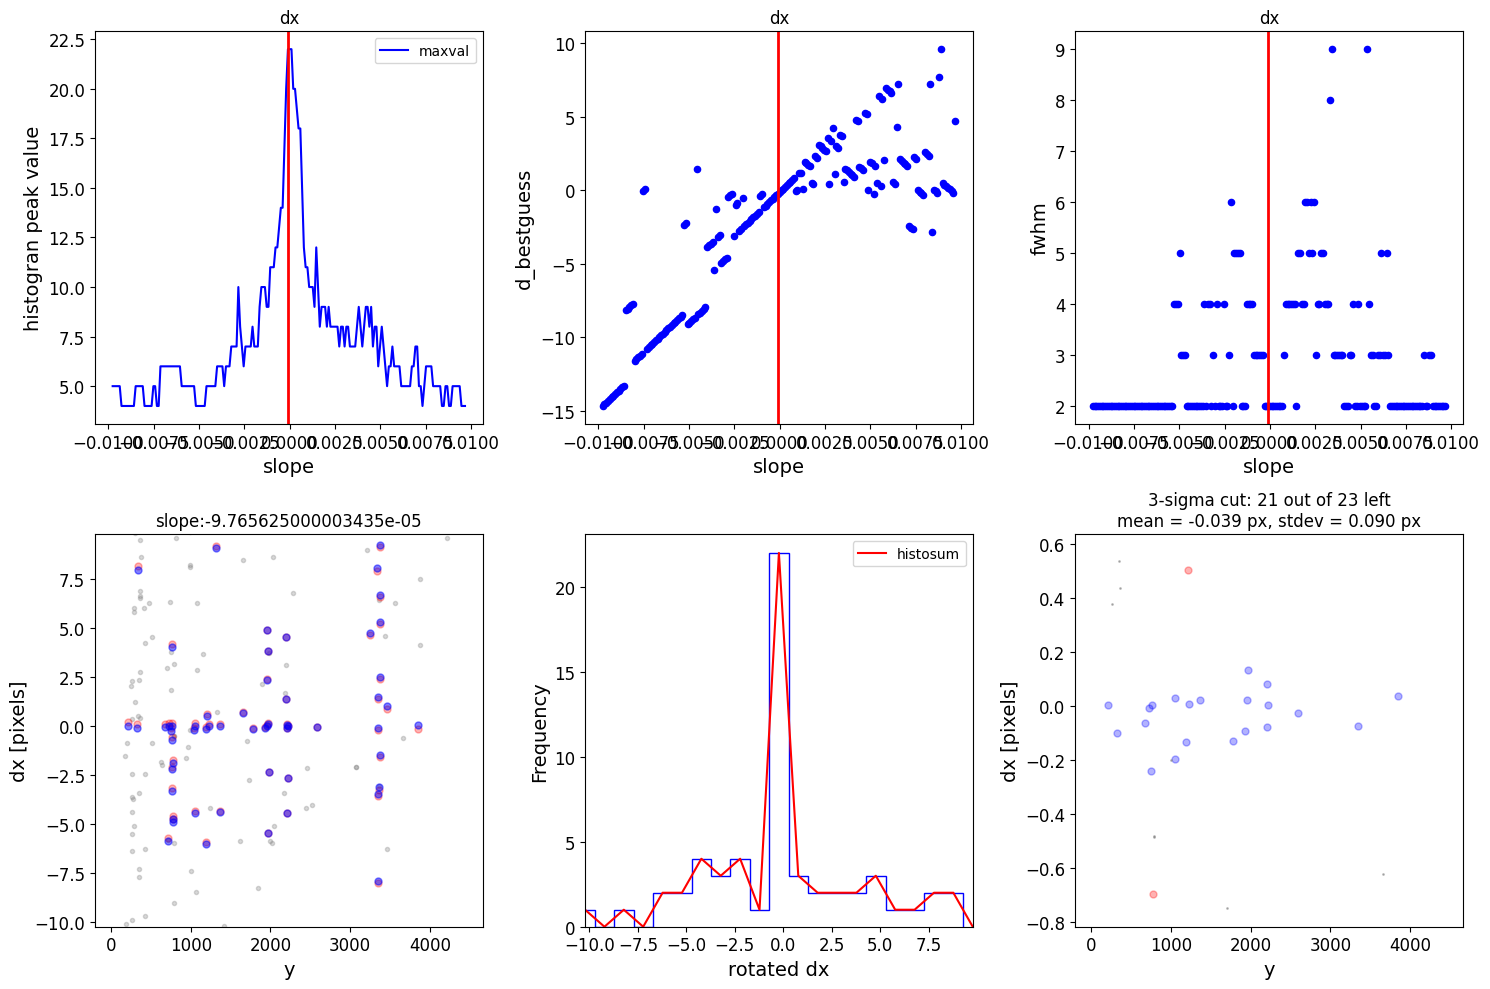

### Doing histogram cut for dy, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000391   0.806836    20.0      1     -0.01835   2.0     False
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.7816504175241705

rough_cut_px=0.8 pixels removes 0 from 21 entries
Keeping 21 out of 21, skippin 0 because of null values in columns d_rot_tmp
median: -0.101300
75.000000 percentile cut: max residual for cut: 0.417049
__tmp_residuals 0.41704942855791094
median: -0.128967
i:00 mean:-0.128967(0.070148) stdev:0.262470(0.047920) X2norm:0.96 Nchanged:0 Ngood:15 N

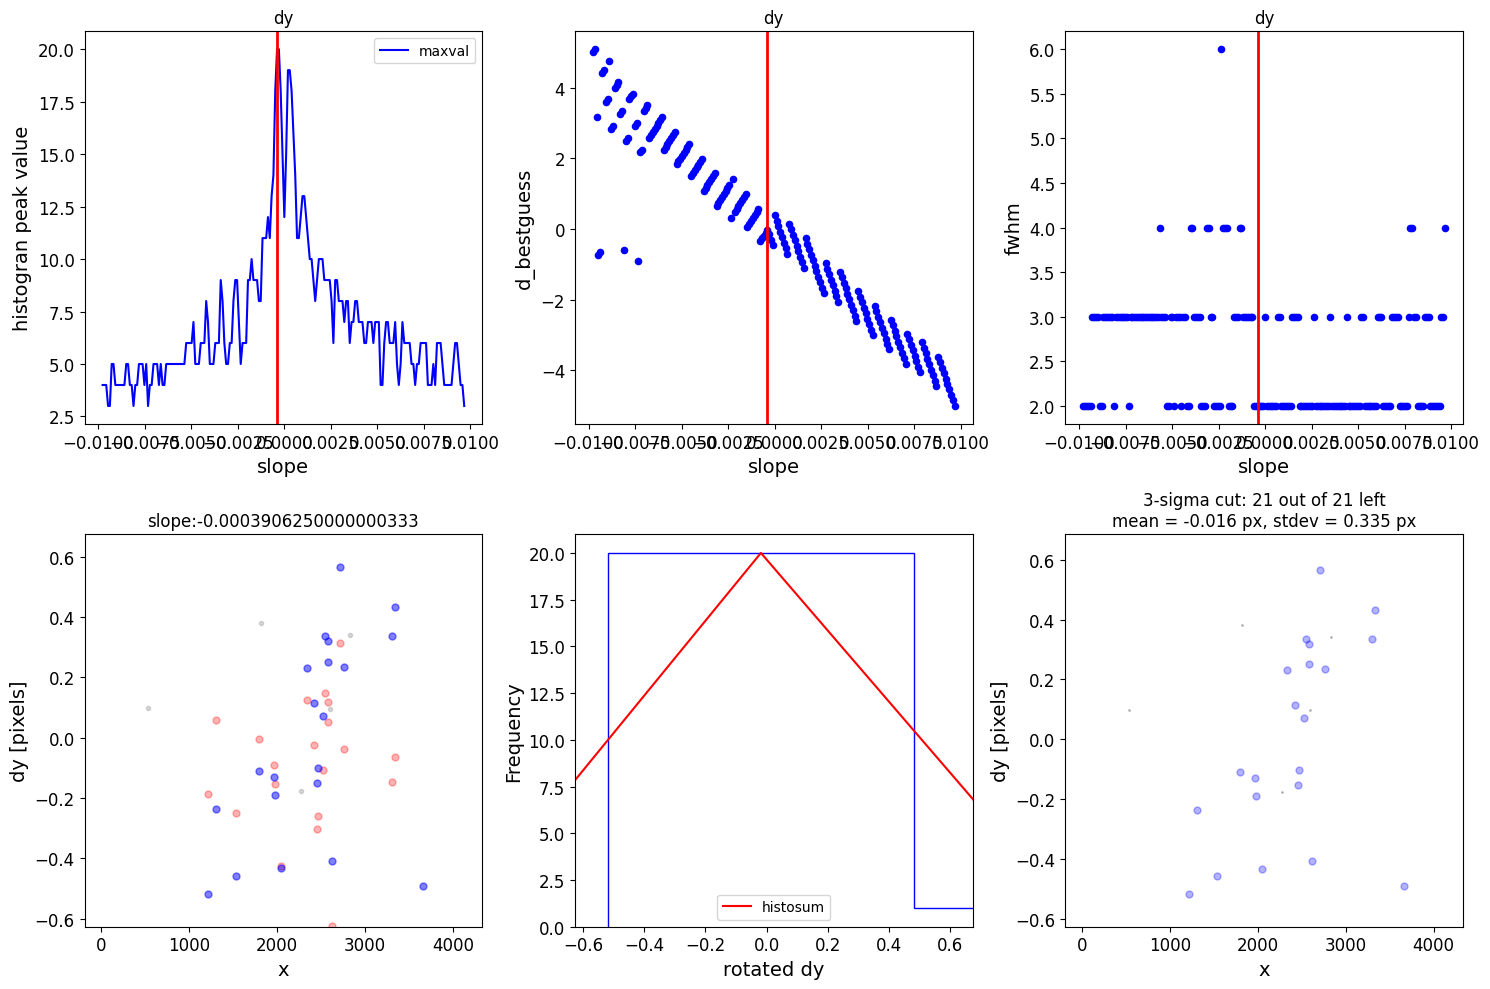

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2025-01-08 12:36:42,432 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2025-01-08 12:36:43,223 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(4477, 4131) from ifab18050_drc.fits>],).
2025-01-08 12:36:43,224 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/aswin/jwst123/sn2024aecx/ifab18050_jhat.fits
  output_dir: ./sn2024aecx
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: general
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  sa

Setting output directory for ifab18050_jhat.fits file to ./sn2024aecx
21 matches are passed to tweakreg general fitting
Fitting tweakreg fitgeometry=general to xy=x,y to ra,dec=gaia_ra,gaia_dec


2025-01-08 12:36:43,580 - stpipe.TweakRegStep - INFO - Step TweakRegStep done


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
WCSAXES 2 2
CRPIX1 2065.5 2065.5
CRPIX2 2238.5 2238.5
CUNIT1 deg deg
CUNIT2 deg deg
CRVAL1 166.4596419699959 166.45964074512
CRVAL2 -0.05084223950101563 -0.050841106031062
CRDER1 2.93243298885197e-06 2.932432988852e-06
CRDER2 4.15148951848922e-06 4.1514895184892e-06
WCSNAME IDC_2731450pi-FIT_REL_GAIAeDR3 IDC_2731450pi-FIT_REL_GAIAeDR3
RADESYS ICRS ICRS


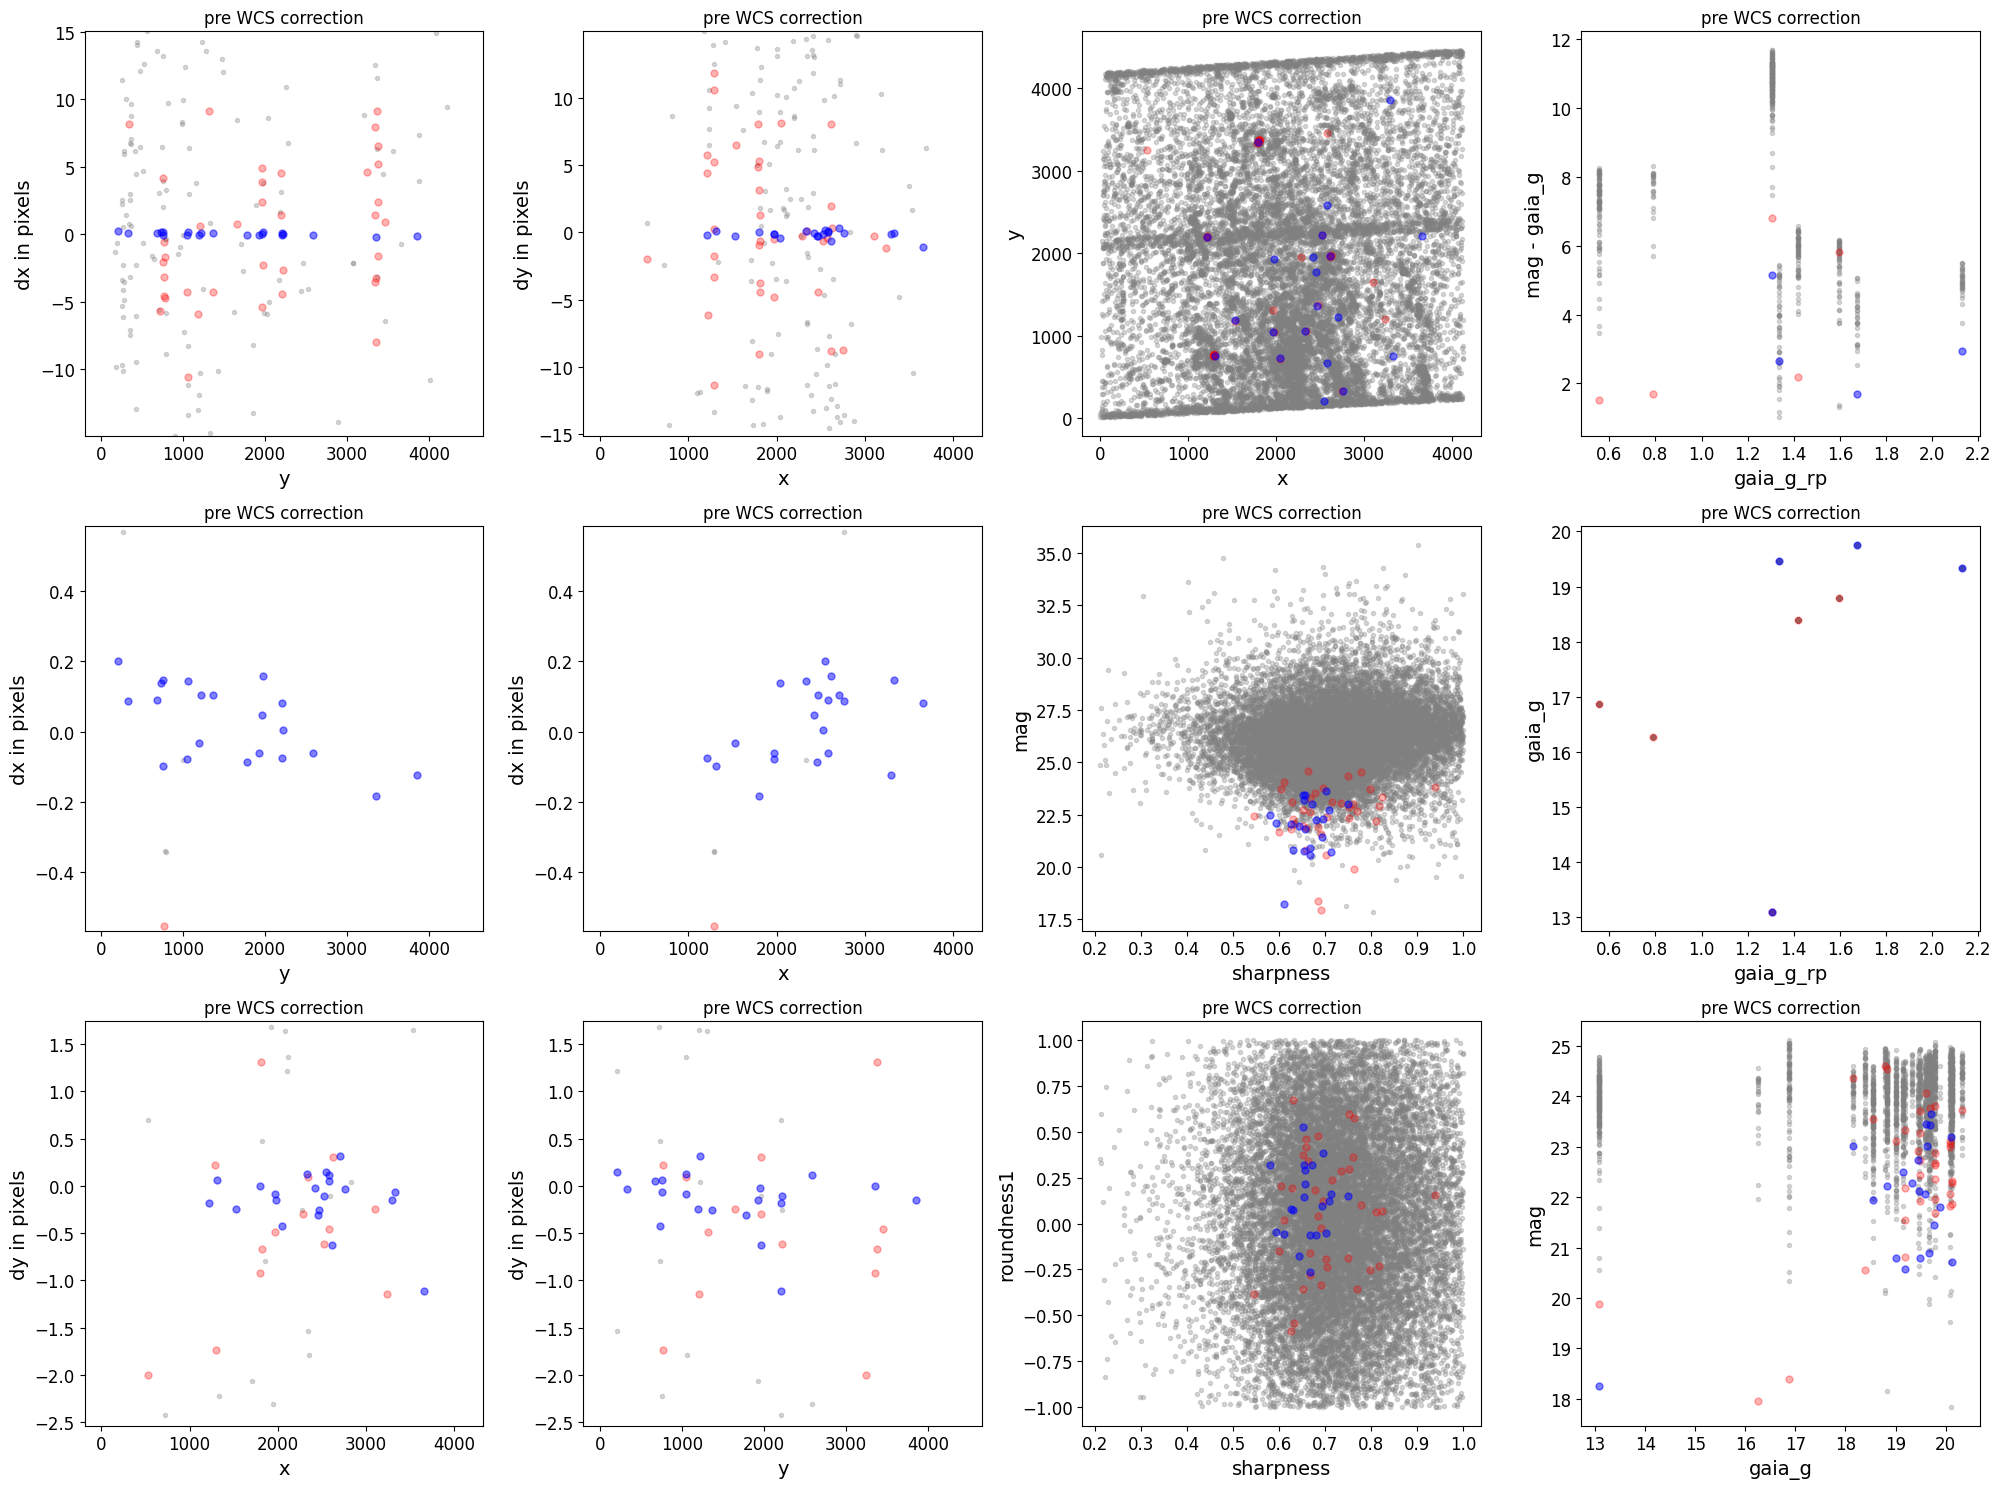

./sn2024aecx/ifab18050_jhat.fits
Saving ./sn2024aecx/ifab18050_jhat.good.phot.txt
Saving ./sn2024aecx/ifab18050_jhat.all.phot.txt


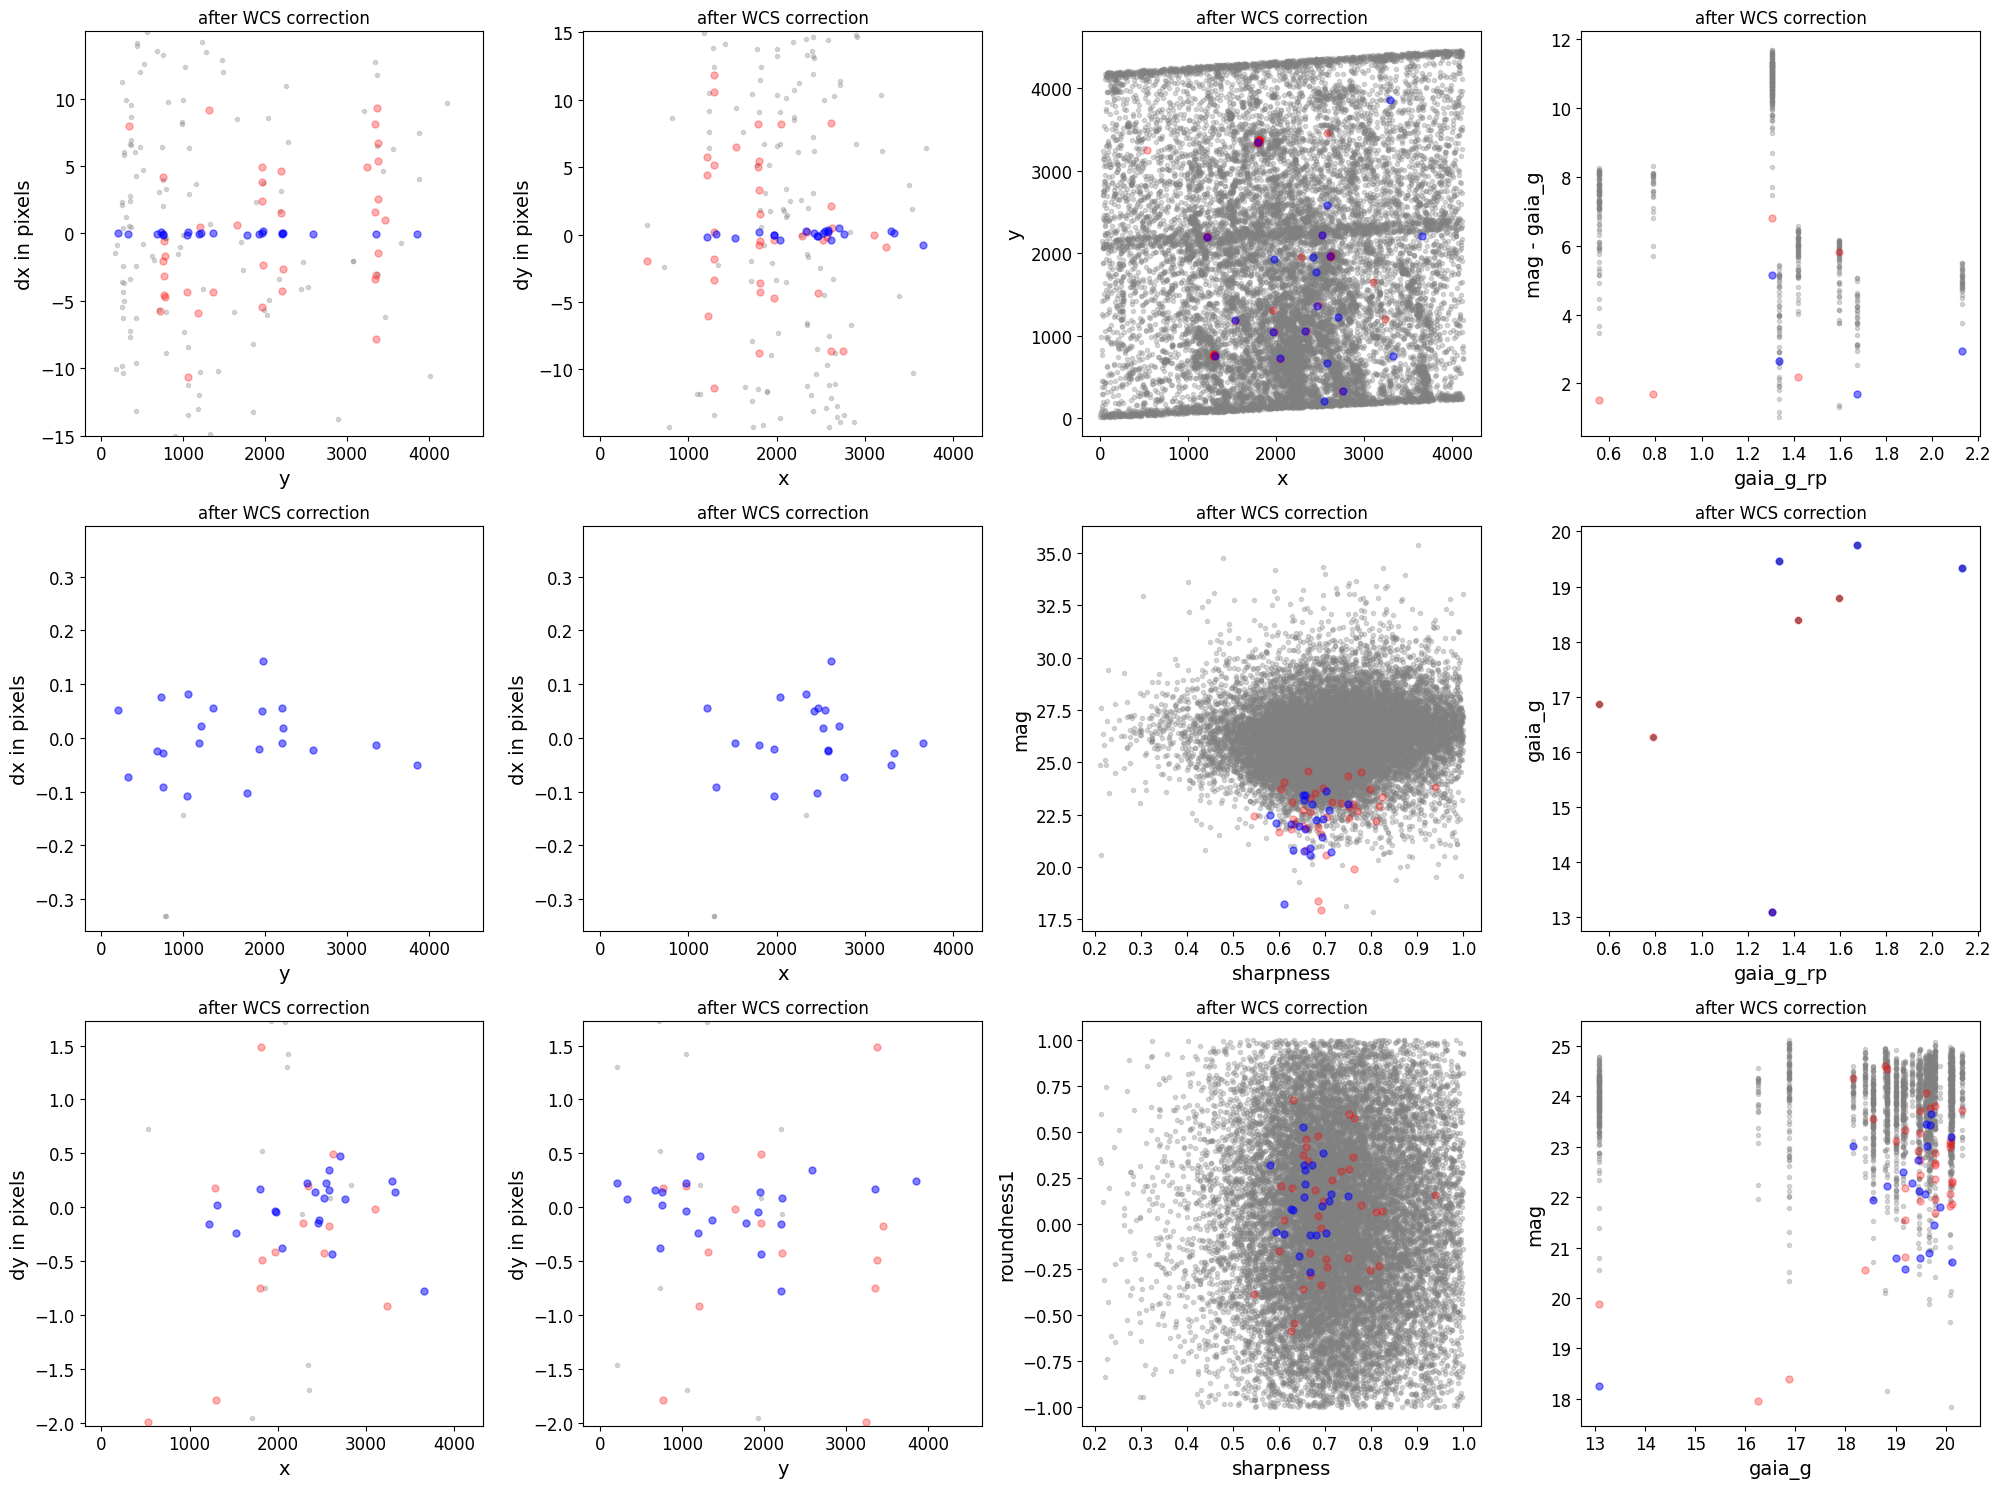

*** Note: close plots to continue!


0

In [3]:
wcs_align = st_wcs_align()
    
wcs_align.run_all(align_image,
          telescope='hst',
          outsubdir='sn2024aecx',
          overwrite=True,
          d2d_max=0.5, 
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          refcat_pmflag = True,
          histocut_order='dxdy',
          use_dq = False,
          verbose = True,
          iterate_with_xyshifts = True,
          xshift = 0,
          yshift = 0,
              sharpness_lim=(0.3,0.95),
              roundness1_lim=(-0.7, 0.7),
              # Nbright = 200,
              SNR_min= 5,
              dmag_max=.1,
              # objmag_lim =(15,22),
              # refmag_lim = (12,19),
              binsize_px = 1.0,
              saveplots = 0,
              slope_min = -20/2048,
              savephottable = 3)

In [4]:
wcs_align = st_wcs_align()
    
wcs_align.run_all(align_image,
          telescope='jwst',
          outsubdir='jwstred_temp_gaia',
          overwrite=True,
          d2d_max=0.5, 
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          refcat_pmflag = True,
          histocut_order='dxdy',
          use_dq = False,
          verbose = True,
          iterate_with_xyshifts = True,
          xshift = 0,
          yshift = 0,
              sharpness_lim=(0.3,0.95),
              roundness1_lim=(-0.7, 0.7),
              # Nbright = 200,
              SNR_min= 5,
              dmag_max=.1,
              objmag_lim =(15,22),
              # refmag_lim = (12,19),
              binsize_px = 1.0,
              saveplots = 0,
              slope_min = -20/2048,
              savephottable = 3)

telescope set to jwst

### Doing photometry on sn2024aecx/ifab18050_drc.fits
True ./jwstred_temp_gaia/ifab18050.phot.txt
photometry catalog filename: ./jwstred_temp_gaia/ifab18050.phot.txt


AttributeError: No attribute 'wcs'

In [4]:
jhat_image = align_image.replace('i2d', 'jhat_i2d')

In [5]:
jhat_image

'jwstred_temp_dolphot/out_filter/f150w_jhat_i2d.fits'

In [6]:
image_model = ImageModel(jhat_image)
# phot.t[refcat_xcol], phot.t[refcat_ycol] = image_model.meta.wcs.world_to_pixel(SkyCoord(phot.t[refcat_racol],
#     phot.t[refcat_deccol],unit=u.deg))
# sc = image_model.meta.wcs.pixel_to_world(phot.t['x'],phot.t['y'])
# phot.t['ra'] = sc.ra.value
# phot.t['dec'] = sc.dec.value

In [7]:
ast_wcs

NameError: name 'ast_wcs' is not defined

In [40]:
type(image_model.meta.wcs)

gwcs.wcs.WCS

In [8]:
from asdf import AsdfFile
tree = {"wcs": image_model.meta.wcs}
wcs_file = AsdfFile(tree)
wcs_file.write_to("wcs.asdf")

In [9]:
ast_wcs = wcs.WCS(fits.open(jhat_image)['SCI'].header)
ast_ra, ast_dec = ast_wcs.all_pix2world([1030], [1034], 0)

In [10]:
ast_c = SkyCoord(ast_ra*u.deg, ast_dec*u.deg)

In [11]:
modelc = image_model.meta.wcs.pixel_to_world([1030], [1034])

In [12]:
imcoord = SkyCoord([259.3012246]*u.deg, [43.1284878]*u.deg)

In [13]:
imcoord.separation(modelc)

<Angle [0.00055292] deg>

In [14]:
imcoord.separation(ast_c)

<Angle [1.23356737e-05] deg>

#### Gaia xmatch

In [39]:
def cut_gaia_sources(image, table_gaia):
    im = fits.open(image)
    hdr = im['SCI'].header
    w = wcs.WCS(hdr)
    nx, ny = hdr['NAXIS1'], hdr['NAXIS2']

    pix_coords = w.all_world2pix(np.array(table_gaia['ra']), np.array(table_gaia['dec']), 1)
    im_x, im_y = pix_coords[0], pix_coords[1]
    mask = (im_x > 0) & (im_x < nx) & (im_y > 0) & (im_y < ny)

    return table_gaia[mask]

In [40]:
def query_gaia(image, dr = 'gaiadr3', telescope = 'jwst', save_file = False):
    im = fits.open(image)

    hdr = im['SCI'].header
    nx = hdr['NAXIS1']
    ny = hdr['NAXIS2']

    if telescope == 'jwst':
        image_model = ImageModel(im)
        ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
    if telescope == 'hst':
        w = wcs.WCS(hdr)
        ra0, dec0 = w.pixel_to_world_values(nx/2.0-1, ny/2.0-1)
        
    #find radius of query region usinng image header
    coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
    radius_deg = []
    for x in [0,nx-1]:        
        for y in [0,ny-1]:
            if telescope == 'jwst':
                ra, dec = image_model.meta.wcs(x,y)
            if telescope == 'hst':
                ra, dec = w.pixel_to_world_values(x, y)
            radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
    radius_deg = np.amax(radius_deg)*1.1

    #query gaia
    query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
            {}.gaia_source.ra,{}.gaia_source.dec),\
            CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

    job5 = Gaia.launch_job_async(query)
    tb_gaia = job5.get_results() 
    tb_gaia = cut_gaia_sources(image, tb_gaia)
    print("Number of Gaia stars:",len(tb_gaia))
    
    if save_file:
        print(f'Saving Gaia query to {save_file}')
        np.savetxt(save_file, np.array(tb_gaia[['ra', 'dec']]), fmt = '%s')
    
    return tb_gaia

In [41]:
def calc_dispersion(gaia_table, phot_file, phot_image = False, dist_limit = 1, plot = False, inspect_large_offset = False):
    jhat_df = pd.read_csv(phot_file, sep = '\s+') #read phot file with uneven spacing

    if phot_image:
        hdr = fits.open(phot_image)['SCI'].header
        w = wcs.WCS(hdr)
        jh_radec = w.all_pix2world(jhat_df['x'], jhat_df['y'], 0)
        jh_ra, jh_dec = np.array(jh_radec[0])*u.degree, np.array(jh_radec[1])*u.degree
        jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
    else:      
        jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
        jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
    ga_ra, ga_dec = np.array(gaia_table['ra'])*u.degree, np.array(gaia_table['dec'])*u.degree
    ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)
    
    dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=dist_limit)
    if inspect_large_offset:
        dmask = dist_matched_df['d2d'] > 0.1
        np.savetxt('jwstred_temp_gaia/jwst_large_offset.txt', np.column_stack((np.array(jh_skycoord[dist_matched_df[dmask]['idx_1']].ra.degree),
                       np.array(jh_skycoord[dist_matched_df[dmask]['idx_1']].dec.degree))), fmt='%s', delimiter = ',')
        np.savetxt('jwstred_temp_gaia/gaia_large_offset.txt', np.column_stack((np.array(ga_skycoord[dist_matched_df[dmask]['idx_2']].ra.degree),
                       np.array(ga_skycoord[dist_matched_df[dmask]['idx_2']].dec.degree))), fmt='%s', delimiter = ',')

    clip_mean, clip_median, clip_std = sigma_clipped_stats(dist_matched_df['d2d']**2)
    print(clip_mean, clip_median, clip_std)
    dispersion = np.sqrt(clip_mean)
    
    if plot:
        plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
                 linestyle = '--', color = 'cornflowerblue')
        plt.xlabel('d2d (arcsec)')
        plt.ylabel('frequency')
        plt.title('JWST-Gaia xmatch')
        plt.grid(alpha = 0.2, linestyle = '--')
        plt.savefig('i2.png', dpi = 500, bbox_inches = 'tight')
        plt.show()
        
    return dispersion

In [42]:
tb_gaia = query_gaia('sn2024aecx/ifab18050_drc.fits', telescope = 'hst', save_file = 'sn2024aecx/all_gaia_locs.txt')

2025-01-08 12:56:11,704 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of Gaia stars: 40
Saving Gaia query to sn2024aecx/all_gaia_locs.txt


In [43]:
tb_gaia

<Table length=40>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 3804214819407396096 ...           MARCS
1636148068921376768 Gaia DR3 3804215025565206528 ...                
1636148068921376768 Gaia DR3 3804215128645013120 ...                
1636148068921376768 Gaia DR3 3804215163003885824 ...                
1636148068921376768 Gaia DR3 3804215163004751616 ...           MARCS
1636148068921376768 Gaia DR3 3804215197363748352 ...                
1636148068921376768 Gaia DR3 3804215197363830784 ...                
1636148068921376768 Gaia DR3 3804215227431340800 ...                
1636148068921376768 Gaia DR3 3804215231723364352 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 3804215437882717440 ...                
1636148068921376768 Gaia DR3 3804215437882932352 ...                
1636148068921376768 Gaia DR3 3804215502309242240 ...                
1636148068921376768 Gaia DR3 3804215540961067264 ...           MARCS
1636148068921376768 Gaia DR3 3804215540961067776 ...                
1636148068921376768 Gaia DR3 3804215540961169280 ...                
1636148068921376768 Gaia DR3 3804215540961169664 ...                
1636148068921376768 Gaia DR3 3804215540961364352 ...                
1636148068921376768 Gaia DR3 3804215540962149760 ...

0.00044653215144153653 0.00010301205924317781 0.0006343911968319231


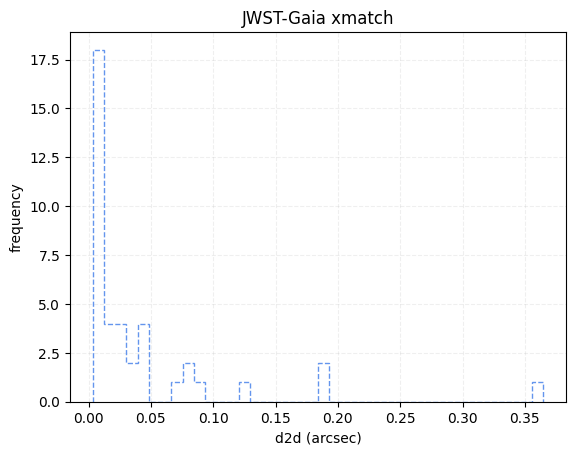

0.02113130737653344

In [46]:
calc_dispersion(tb_gaia, align_image.replace('_drc.fits', '.phot.txt'), phot_image = align_image, plot = True)

In [51]:
jwst_phot = hst_photclass()
phot_img = glob.glob(align_image.replace('drc.fits', 'jhat_drc.fits'))[0]
jwst_phot.run_phot(imagename=phot_img,
                   photfilename='sn2024aecx/jhat_corr_phot.txt',
                   overwrite=True,
                   ee_radius=70,
#                    use_dq=True,
                   SNR_min = 3,
                   find_stars_threshold = 5)
# ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read('sn2024aecx/jhat_corr_phot.txt',format='ascii')
print(refcat)

0 sn2024aecx/jhat_corr_phot.txt
dmag 0.36200000000000004
aper_sum_4.0px annulus_median_4.0px aper_bkg_4.0px ...     ra        dec   
-------------- -------------------- -------------- ... ---------- ---------
      9.496923            -0.001653      -0.083101 ... 166.430261 -0.037686
      9.173175            -0.001801      -0.090535 ... 166.429821 -0.037911
      2.243962            -0.002588      -0.130105 ... 166.433419 -0.036341
      2.837694            -0.002623      -0.131842 ... 166.430819 -0.037567
     16.092938            -0.001075      -0.054043 ... 166.430716 -0.037657
      2.070579            -0.001299      -0.065294 ... 166.433396 -0.036394
      4.112296            -0.001159      -0.058279 ... 166.434107 -0.036071
      3.683722            -0.001233      -0.061978 ... 166.434507   -0.0359
      3.630309            -0.001281      -0.064368 ... 166.430747 -0.037705
      0.178283            -0.002645      -0.132932 ... 166.431496 -0.037364
           ...                 

0.0003845972261050583 9.183405456736746e-05 0.0004915420043677629


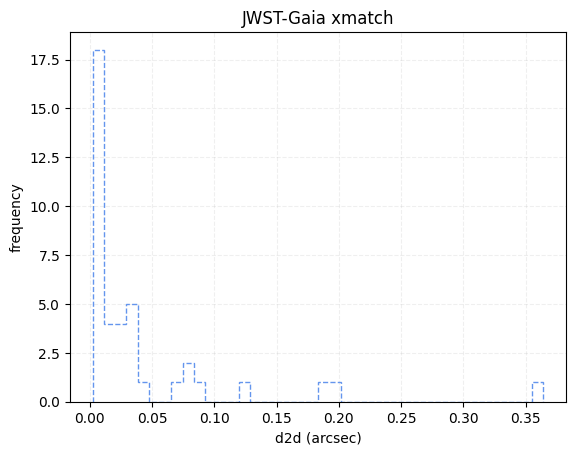

0.019611150555361567

In [52]:
calc_dispersion(tb_gaia, 'sn2024aecx//jhat_corr_phot.txt', 
                phot_image = phot_img,
                dist_limit = 1.0, plot = True, inspect_large_offset=True)

#### Breakup star mask

In [18]:
jwst_im = fits.open(glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')[0])

In [19]:
jwst_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


In [20]:
dq_mask = deepcopy(jwst_im['DQ'].data)

In [21]:
flag_sat = np.array(dq_mask != 1) & np.array(dq_mask != 2) & np.array(dq_mask != 3)

In [22]:
np.shape(flag_sat), np.shape(dq_mask)

((2048, 2048), (2048, 2048))

In [23]:
flag_sat.sum()

4165548

In [24]:
dq_mask[flag_sat] = 10
dq_mask[~flag_sat] = 1

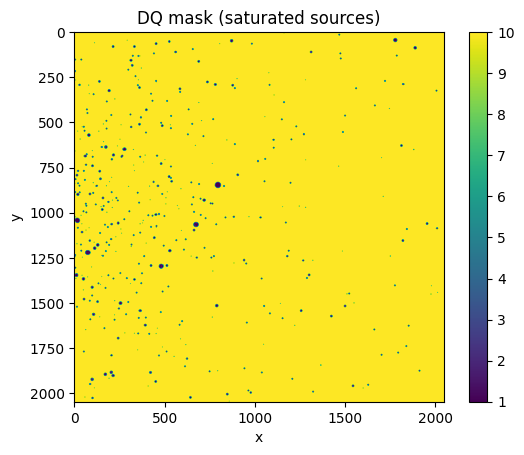

In [26]:
plt.imshow(dq_mask)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('DQ mask (saturated sources)')
plt.show()
# plt.savefig('dq_mask.png', bbox_inches = 'tight', dpi = 500)

In [27]:
np.unique(dq_mask)

array([ 1, 10], dtype=uint32)

In [36]:
def expand_mask(mask, size = 40, mask_shape = 'square'):
    """
    Expand the mask by a given size using binary dilation.

    Parameters
    ----------
    mask : numpy.ndarray
        The mask to be expanded.
    size : int
        The size of the structuring element used for binary dilation.
    mask_shape : str
        The shape of the structuring element. Can be 'square' or 'circle'.

    Returns
    -------
    mask_exp : numpy.ndarray
        The expanded mask.
    """
    # Create a binary mask where pixels with flag 1 are set to True
    binary_mask = (mask == 1)
    
    # Define a structuring element
    if mask_shape == 'square':
        structuring_element = np.ones((size, size), dtype=bool)
    if mask_shape == 'circle':
        y, x = np.ogrid[:size, :size]
        center = (size-1)/2
        structuring_element = (x - center)**2 + (y - center)**2 <= center**2
    
    expanded_mask = binary_dilation(binary_mask, structure=structuring_element)
    
    # Convert the expanded binary mask back to the original mask format
    mask_exp = np.where(expanded_mask, 1, mask)
    
    return mask_exp

In [41]:
expmask = expand_mask(dq_mask, mask_shape = 'circle')
expmask[expmask == 1] = False
expmask[expmask == 10] = True
# expmask[expmask == 1] = True

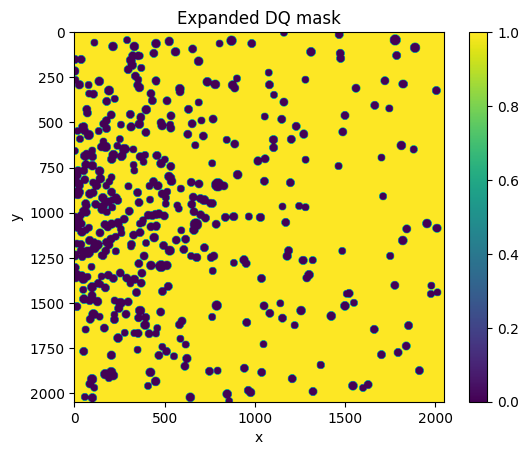

In [42]:
# expmask[expmask > 10] = 10
plt.imshow(expmask)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expanded DQ mask')
plt.show()
# plt.savefig('exp_dq_mask.png', bbox_inches = 'tight', dpi = 500)

In [43]:
expmask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint32)

In [17]:
plt.imshow(jwst_im['SCI'].data, vmin = np.nanmedian(jwst_im['SCI'].data) - 1*np.nanstd(jwst_im['SCI'].data),
                                vmax = np.nanmedian(jwst_im['SCI'].data) + 1*np.nanstd(jwst_im['SCI'].data))
plt.colorbar()

In [307]:
# masked_im = np.where(dq_mask, jwst_im['SCI'].data, 3)
masked_im = np.where(expmask, jwst_im['SCI'].data, np.nan)

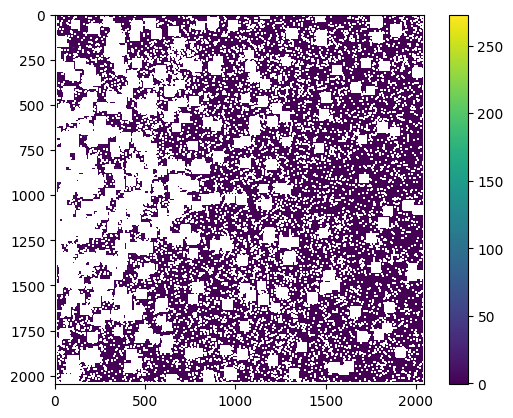

In [308]:
plt.imshow(masked_im)
plt.colorbar()

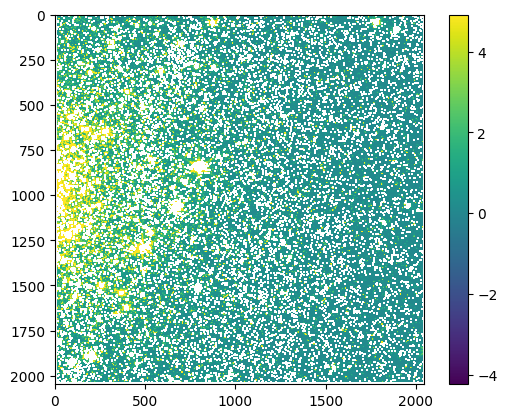

In [38]:
plt.imshow(masked_im, vmin = np.nanmedian(masked_im) - 1*np.nanstd(masked_im),
                      vmax = np.nanmedian(masked_im) + 1*np.nanstd(masked_im))
plt.colorbar()

In [309]:
jwst_im['SCI'].data = masked_im

In [44]:
# bin_dq_hdu = 
data, hdr = fits.getdata('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits', ext=3, header=True)
# bin_dq_data = np.where(expmask, jwst_im['DQ'].data, 3)
hdr['extname'] = 'BIN_DQ'
image_hdu = fits.ImageHDU(data=expmask, name="BIN_DQ", header = hdr)
jwst_im.insert(8, image_hdu)
# bin_dq_hdu

In [45]:
jwst_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   uint32   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  BIN_DQ        1 ImageHDU        11   (2048, 2048)   uint32   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


In [46]:
jwst_im.writeto('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_masked.fits', overwrite = True)

In [48]:
def add_bin_dq(filename):
    im = fits.open(filename)
    dq_mask = deepcopy(im['DQ'].data)

    flag_sat = np.array(dq_mask != 1) & np.array(dq_mask != 2) & np.array(dq_mask != 3)
    dq_mask[flag_sat] = 10
    dq_mask[~flag_sat] = 1

    expmask = expand_mask(dq_mask, mask_shape = 'circle')
    expmask[expmask == 10] = False
    expmask[expmask == 1] = True

    data, hdr = fits.getdata(filename, ext=3, header=True)
    hdr['extname'] = 'BIN_DQ'
    image_hdu = fits.ImageHDU(data=expmask, name="BIN_DQ", header = hdr)
    im.insert(8, image_hdu)
    im.writeto(filename.replace('.fits', '_masked.fits'), overwrite = True)


In [49]:
add_bin_dq('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')

In [51]:
im = fits.open('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_masked.fits')

In [ ]:
def prepare_image(data_original, imhdr, area=None, dq=None, 
                  DNunits=False, dq_ignore_bits = 4):
    # dq_ignore_bits contains the bits in the dq which are still ok, so they
    # should be ignored.
    # 2 = Pixel saturated during integration
    # 4 = Jump detected during integration

    if area is not None:

        if self.verbose: print('Applying Pixel Area Map')

        data_pam = data_original * area

    else:

        data_pam = data_original

    if DNunits:
        if imhdr["BUNIT"]!='MJy/sr':
            raise RuntimeError(f'imhdr["BUNIT"]={imhdr["BUNIT"]} is not MJy/sr!')
        if self.verbose: print(f'Converting units from {imhdr["BUNIT"]} to DN/s')
        data = data_pam / imhdr['PHOTMJSR']
    else:
        data = data_pam


    if dq is not None:
        # dq_ignore_bits are removed from the mask!
        #fits.writeto('TEST_dq_delme.fits',dq,overwrite=True,output_verify='ignore')
        mask = np.bitwise_and(dq,np.full(data_original.shape, ~dq_ignore_bits, dtype='int'))
    else:
        mask = np.zeros(data_original.shape, dtype='int')

    # hijack a few bits for our purposes...
    mask[np.isnan(data)==True] = 8
    mask[np.isfinite(data)==False] = 8
    mask[np.where(data==0)] = 16

    #fits.writeto('TEST_mask_delme.fits',mask,overwrite=True,output_verify='ignore')

    data[mask>0] = np.nan

    return data,mask,DNunits

In [19]:
test_im = fits.open('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')

In [20]:
test_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  BIN_DQ        1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


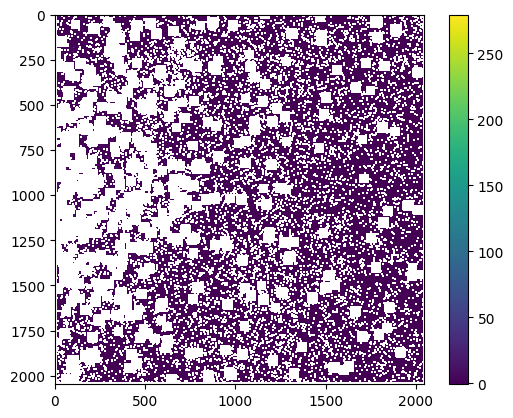

In [24]:
plt.imshow(data)
plt.colorbar()

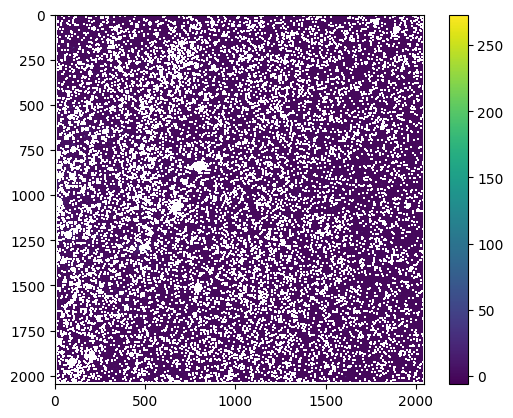

In [15]:
plt.imshow(test_im['SCI'].data)
plt.colorbar()

In [275]:
dq = test_im['BIN_DQ'].data
og_data = np.array(test_im['SCI'].data)
dq_ignore_bits = 4
mask = np.bitwise_and(dq, np.full(og_data.shape, ~dq_ignore_bits, dtype = 'int'))

In [247]:
dq

array([[2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       ...,
       [2155347969, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665]], dtype=uint32)

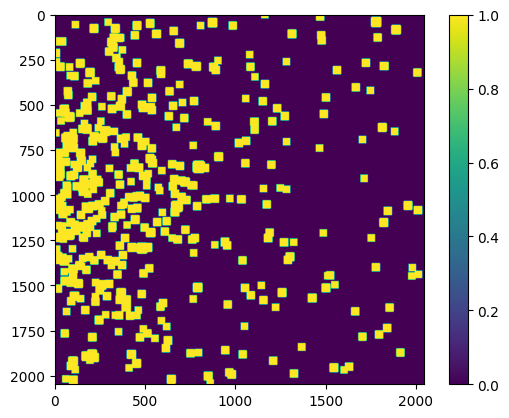

In [276]:
# mask = np.array(mask, dtype = 'float32')
# mask[mask>0] = np.nan
plt.imshow(mask)
plt.colorbar()

In [148]:
np.bitwise_and(np.array([1]), np.array([5]))

array([1])

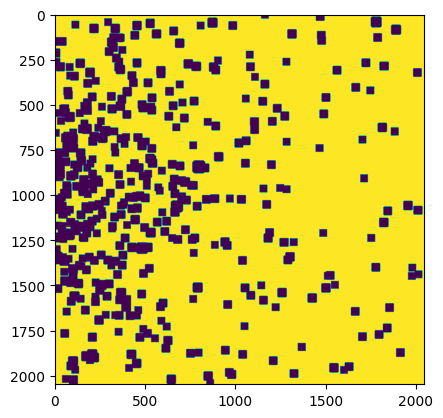

In [142]:
plt.imshow(dq)